In [1]:
building_id = 1
price = 400
iteration = 0

In [2]:
# Parameters
building_id = 2
price = 106
iteration = 0


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############

# EnergyPlus
output_dir = 'energy_plus/output_energy_plus'
error_dir  = 'energy_plus/output_energy_plus'
# EHUB
res_file   = 'ehub/output_ehub_excel/' + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"

# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

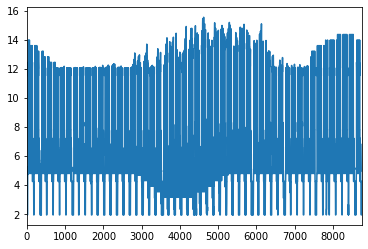

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [12]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m²
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [13]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

numpy.ndarray

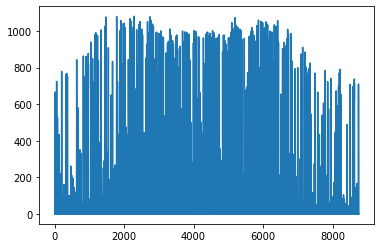

In [14]:
irr = pvpanel.irradiance(180,45,0.6)
plt.plot(irr);
type(irr)

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


[180, 215, 245, 5, 55, 10, 0.9, 0.35, 0.9]
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63
Start Evaluation
Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 5.0
                                           and a gcr of 0.900
Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 55.0
                                           and a gcr of 0.350
Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 10.0
                                           and a gcr of 0.900
Generated the panel irradiance

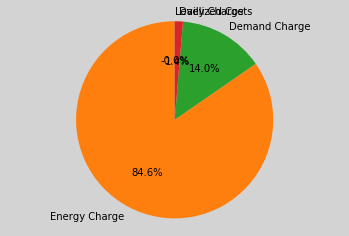

Total roof area of the  building: 599 m²
Total roof area used 0 m²
Percentage: 0.0%


In [15]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [5,55,10,35,5]
    gcr = [0.9,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [5,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)
print(pan_vals)
# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 7,206 per year


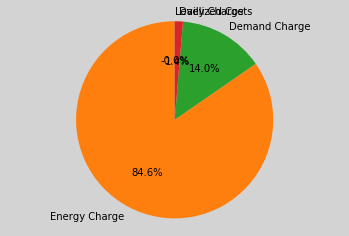

In [16]:
my_model.make_pie_chart()

In [17]:
my_model.costBreak

{'Levelized Costs': -0.002599999999617353,
 'Energy Charge': 6097.99,
 'Demand Charge': 1010.1281000000001,
 'Daily Charge': 97.5645}

In [18]:
my_model.generated_percentage()

Total Electricity Load from the building: 61,846 kWh
Total Electricity Generated from PV: 0 kWh
Percentage: 0.0%


In [19]:
my_model.roof_percentage()

Total roof area of the  building: 599 m²
Total roof area used 0 m²
Percentage: 0.0%


In [20]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    1010.1281
dtype: float64

In [21]:
print(my_model.solveResults['solution']['energy_exported']['GreenElec'].sum())
print(my_model.solveResults['solution']['energy_imported'].max())

print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['total_import'])
print(my_model.solveResults['solution']['total_import_cost'])
print(my_model.solveResults['solution']['total_export_income'])

0.0
Grid    15.5361
dtype: float64
0.0
61845.7
6097.99
0.0


In [22]:
print(my_model.solveResults['solution']['max_energy_billing'])
print(my_model.solveResults['solution']['max_energy_billing'].sum())

print(my_model.solveResults['solution']['above_550'])
print(my_model.solveResults['solution']['above_35'])
print(my_model.solveResults['solution']['above_150'])

     max_energy_billing
Apr             13.0761
Aug             15.1786
Dec             14.3522
Feb             12.1588
Jan             13.9684
Jul             35.0000
Jun             14.8989
Mar             12.2439
May             13.6837
Nov             13.9684
Oct             12.7610
Sep             15.0807
max_energy_billing    186.3707
dtype: float64
0
     above_35
Apr         0
Aug         0
Dec         0
Feb         0
Jan         0
Jul         1
Jun         0
Mar         0
May         0
Nov         0
Oct         0
Sep         0
     above_150
Apr          0
Aug          0
Dec          0
Feb          0
Jan          0
Jul          0
Jun          0
Mar          0
May          0
Nov          0
Oct          0
Sep          0


In [23]:
my_model.solveResults['solution']['any_above_35']

1

In [24]:
my_model.solveResults['solution']['above_550']

0

In [25]:
my_model.solveResults['solution']['any_above_150']

0

In [26]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [27]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63
Start Evaluation
Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.350
Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.350


100%|██████████| 2190/2190 [00:11<00:00, 192.78it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 11.536373138427734 sec


Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 51.0
                                           and a gcr of 0.800
Generated the panel irradiance in  12s
Starting recompile
Recompiled the model in 101s
Starting solver
Solved the model in 92s
[0.0, 175.223, 78.4986]
2653.06
0.0
133.042
Total Electricity Imported from the grid 58,561 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 2,653 per year


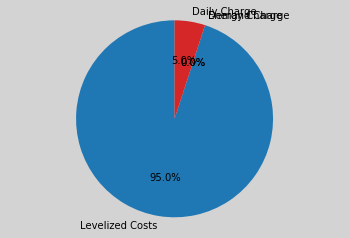

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63
Start Evaluation
Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.250
Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.900
Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.700


100%|██████████| 2190/2190 [00:11<00:00, 192.03it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 11.589200735092163 sec


Generated the panel irradiance in  12s
Starting recompile
Recompiled the model in 101s
Starting solver
Solved the model in 119s
[0.0, 251.222, 0.0]
2628.23
0.0
133.042
Total Electricity Imported from the grid 57,923 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 2,628 per year


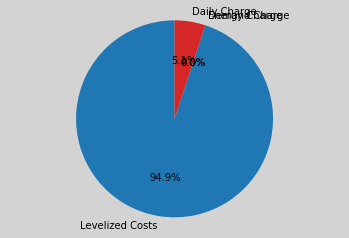

Total roof area of the  building: 599 m²
Total roof area used 279 m²
Percentage: 46.6%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63
Start Evaluation
Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.250
Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.500


100%|██████████| 2190/2190 [00:11<00:00, 193.13it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 11.565922737121582 sec


Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.300


100%|██████████| 2190/2190 [00:11<00:00, 184.82it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 12.032017230987549 sec


Generated the panel irradiance in  24s
Starting recompile


In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","SINGLE")
pvoptimizer.processGA(ga_proc)